# IMPORTS

In [19]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
import os

## Pruebas LingFeng

In [3]:
class GaussianFilter(torch.nn.Module):
    def __init__(self, kernel_size: int, sigma: float):
        super(GaussianFilter, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.kernel = self._create_gaussian_kernel(kernel_size, sigma)
    
    def _create_gaussian_kernel(self, kernel_size: int, sigma: float):
        """Creates a 2D Gaussian kernel."""
        x = torch.arange(kernel_size) - kernel_size // 2
        y = torch.arange(kernel_size) - kernel_size // 2
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        return kernel
    
    def forward(self, x):
        """Applies the Gaussian filter to an input tensor."""
        if x.ndim == 2:  # Add batch and channel dimensions if missing
            x = x.unsqueeze(0).unsqueeze(0)  # Shape [1, 1, H, W]
        
        kernel = self.kernel.to(x.device).unsqueeze(0).unsqueeze(0)  # Shape [1, 1, K, K]
        x = F.conv2d(x, kernel, padding=self.kernel_size // 2)
        return x.squeeze(0).squeeze(0)

In [3]:
dataset = NEUDataset(set="train", transform=None, seed=1, scale=0.5)

# Probar con un DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Intentar iterar sobre el dataloader
for images, labels in dataloader:
    print("Iteración exitosa.")
    print("Imagen shape:", images.shape)
    print("Etiqueta shape:", labels.shape)
    break 

Iteración exitosa.
Imagen shape: torch.Size([4, 1, 100, 100])
Etiqueta shape: torch.Size([4, 6])


In [4]:
image, label = dataset.__getitem__(index=random.randint(2, len(dataset)))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

In [5]:
def optimize_image(image, n_tries: int = 100):
    """
    Optimizes the mean shift parameters to maximize the metric: (Silhouette Score / Number of Clusters).

    Args:
        image (np.array): The input image with shape (200, 200, 3).
        n_tries (int): The number of optimization trials to run.

    Returns:
        dict: The best parameters and the best score.
    """

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        sp = trial.suggest_float("sp", 1.0, 60.0)  # Spatial window radius
        sr = trial.suggest_float("sr", 1.0, 60.0)  # Color window radius

        # Apply mean shift filtering
        after = Perspectiver.meanShift(image, sp, sr)

        # Evaluate clustering
        scores = Perspectiver.evaluate_clustering(image, after)
        score = scores["Davies-Bouldin Index"]
        n_clusters = len(np.unique(after))

        # Avoid division by zero (in case of degenerate clustering)
        if n_clusters == 0:
            return float("-inf")

        # Metric to maximize: Silhouette Score per cluster
        metric_to_maximize = math.log2(score)*n_clusters
        return metric_to_maximize

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }


In [6]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [7]:
BEST = optimize_image(original_image, n_tries=200)["best_params"]
BEST

[I 2025-01-28 18:03:52,247] A new study created in memory with name: no-name-e9f4f118-7c8c-43ae-a152-6760843fe6d8


Using 14 CPU threads for parallel optimization.


[I 2025-01-28 18:03:57,893] Trial 10 finished with value: 731.9303634882937 and parameters: {'sp': 31.9888232625533, 'sr': 30.420587587553456}. Best is trial 10 with value: 731.9303634882937.
[I 2025-01-28 18:03:57,962] Trial 9 finished with value: 610.1110251241956 and parameters: {'sp': 54.75004640673172, 'sr': 30.382512804959106}. Best is trial 10 with value: 731.9303634882937.
[I 2025-01-28 18:03:58,252] Trial 6 finished with value: 807.8661283402179 and parameters: {'sp': 2.0149530464041883, 'sr': 17.293526853820158}. Best is trial 6 with value: 807.8661283402179.
[I 2025-01-28 18:03:58,646] Trial 0 finished with value: 1016.671908807618 and parameters: {'sp': 5.42060923567369, 'sr': 25.513485911487496}. Best is trial 0 with value: 1016.671908807618.
[I 2025-01-28 18:03:58,918] Trial 4 finished with value: 2705.5662337642943 and parameters: {'sp': 18.6736546716724, 'sr': 16.437539823153394}. Best is trial 4 with value: 2705.5662337642943.
[I 2025-01-28 18:03:58,957] Trial 7 finish

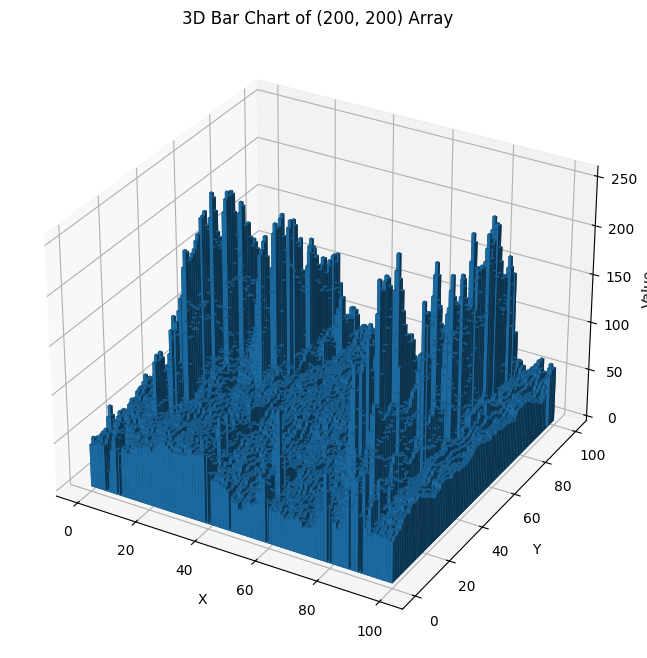

In [8]:
plot_barchartImage(Perspectiver.rgb_to_grayscale(original_image))

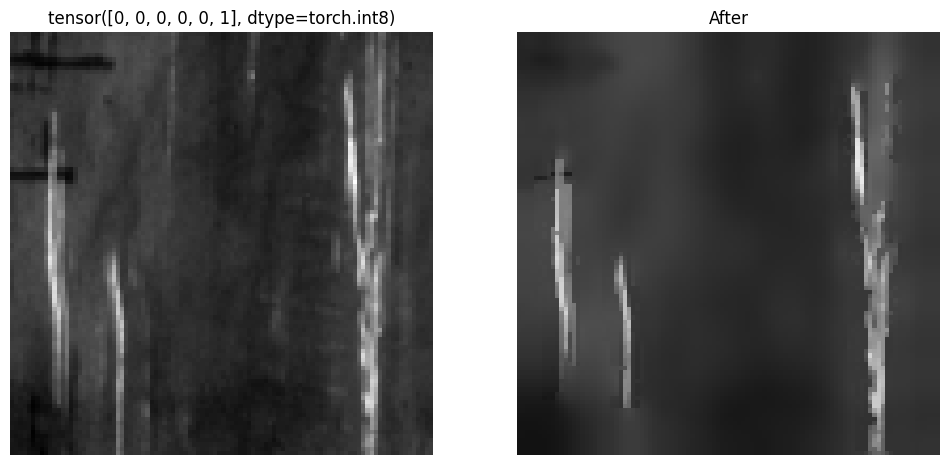

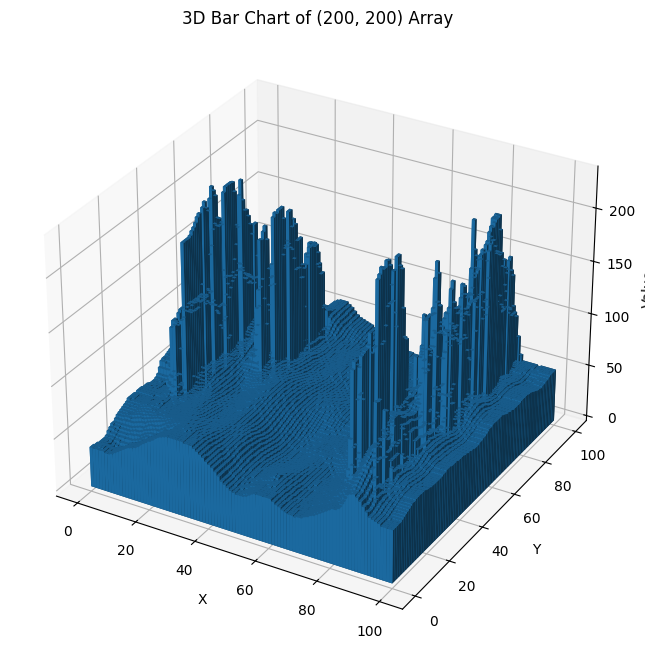

{'Silhouette Score': -0.3190770115477659,
 'Davies-Bouldin Index': 180883.48755756492,
 'Calinski-Harabasz Index': 550.0820024095315,
 'Silhouette Score/n': -0.001579589166078049,
 'Davies-Bouldin Index/n': 895.4628096909155,
 'Calinski-Harabasz Index/n': 2.7231782297501557}

In [9]:
clustered_image = Perspectiver.meanShift(original_image, BEST["sp"], BEST["sr"])
Perspectiver.plotComparison(original_image, clustered_image, titleBefore=label)
plot_barchartImage(Perspectiver.rgb_to_grayscale(clustered_image))
Perspectiver.evaluate_clustering(original_image, clustered_image)

## Pruebas IKER

Carga del dataset

In [2]:
dataset = NEUDataset(set="train", transform=None, seed=1, scale=0.5)

# Probar con un DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Intentar iterar sobre el dataloader
for images, labels in dataloader:
    print("Iteración exitosa.")
    print("Imagen shape:", images.shape)
    print("Etiqueta shape:", labels.shape)
    break 

Iteración exitosa.
Imagen shape: torch.Size([4, 1, 100, 100])
Etiqueta shape: torch.Size([4, 6])


Función auxiliar para obtener imagen aleatoria

In [3]:
def get_random_image():
    
    image, label = dataset.__getitem__(index=random.randint(2, len(dataset)))
    original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

    return original_image, label

In [18]:
def get_image_list(path):

    image_extensions = ('.bmp')
    image_list = []

    image = Image.open(img_path)

    original_width, original_height = image.size
    image = image.resize((max(1, int(original_width * self.scale)), max(1, int(original_height * self.scale))))
    
    image = np.array(image)
    
    for file in os.listdir(path):
        if file.lower().endswith(image_extensions):
            image_list.append(os.path.join(path, file))
    
    return image_list   

'/home/ud/greenAI_project/moe_edging'

In [4]:
def optimize_params(image, n_tries):
    """
    Optimizes the mean shift parameters to maximize the metric: (Silhouette Score / Number of Clusters).

    Args:
        image (np.array): The input image with shape (200, 200, 3).
        n_tries (int): The number of optimization trials to run.

    Returns:
        dict: The best parameters and the best score.
    """

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        sp = trial.suggest_float("sp", 1.0, 60.0)  # Spatial window radius
        sr = trial.suggest_float("sr", 1.0, 60.0)  # Color window radius

        # Apply mean shift filtering
        after = Perspectiver.meanShift(image, sp, sr)

        # Evaluate clustering
        scores = Perspectiver.evaluate_clustering(image, after)
        score = scores["Davies-Bouldin Index"]
        n_clusters = len(np.unique(after))

        # Avoid division by zero (in case of degenerate clustering)
        if n_clusters == 0:
            return float("-inf")

        # Metric to maximize: Silhouette Score per cluster
        metric_to_maximize = math.log2(score)*n_clusters
        return metric_to_maximize

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }


In [5]:
def plot_clustered_image(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [6]:

def get_best_params(img, tries):

    best = optimize_params(img, tries)["best_params"]
    print(best)

    return best

Prueba canny con meanshift

[I 2025-02-05 10:51:54,195] A new study created in memory with name: no-name-4bf248dc-2007-4946-aed4-5376ad52043d


Using 30 CPU threads for parallel optimization.


[I 2025-02-05 10:52:04,827] Trial 7 finished with value: 938.3417056353343 and parameters: {'sp': 45.44792996813219, 'sr': 41.92312538060546}. Best is trial 7 with value: 938.3417056353343.
[I 2025-02-05 10:52:04,938] Trial 18 finished with value: 995.6170405425266 and parameters: {'sp': 8.169466039686839, 'sr': 9.395622576273059}. Best is trial 18 with value: 995.6170405425266.
[I 2025-02-05 10:52:05,365] Trial 21 finished with value: 1600.0022427848812 and parameters: {'sp': 7.336292494861553, 'sr': 49.640952895898835}. Best is trial 21 with value: 1600.0022427848812.
[I 2025-02-05 10:52:05,705] Trial 14 finished with value: 1087.2472611953424 and parameters: {'sp': 37.37537835757293, 'sr': 39.270935827346925}. Best is trial 21 with value: 1600.0022427848812.
[I 2025-02-05 10:52:05,867] Trial 2 finished with value: 1722.4305750571937 and parameters: {'sp': 6.03067276749469, 'sr': 39.31939576121892}. Best is trial 2 with value: 1722.4305750571937.
[I 2025-02-05 10:52:06,053] Trial 29 

{'sp': 4.152586475062298, 'sr': 45.74022006006643}


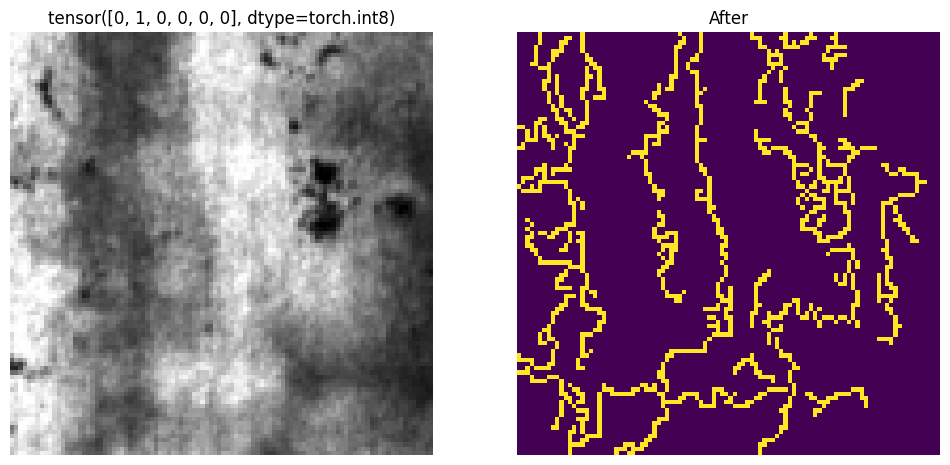

In [17]:
original_image, label = get_random_image()
best = get_best_params(original_image, 100)
img = Perspectiver.meanShift(original_image, best["sp"], best["sr"])
canny_img = Perspectiver.canny_filter(img, 75, 200)
Perspectiver.plotComparison(original_image, canny_img, titleBefore=label)

In [ ]:
crazing = get_image_list('metal_dataset/test/Crazing')
inclusion = get_image_list('metal_dataset/test/Inclusion')
patches = get_image_list('metal_dataset/test/Patches')
pitted = get_image_list('metal_dataset/test/Pitted')
rolled = get_image_list('metal_dataset/test/Rolled')
scratches = get_image_list('metal_dataset/test/Scratches')

cr_orig = crazing[0]
original_image, label = get_random_image()
best = get_best_params(original_image, 100)
img = Perspectiver.meanShift(original_image, best["sp"], best["sr"])
canny_img = Perspectiver.canny_filter(img, 75, 200)
Perspectiver.plotComparison(original_image, canny_img, titleBefore=label)

metal_dataset/test